# QAOA-GPT: GPT model for generating efficient QAOA quantum circuit.

In this tutorial, we will explain the QAOA-GPT workflow introduced in this [paper](https://arxiv.org/pdf/2504.16350):  Ilya Tyagin, Marwa Farag, Kyle Sherbert, Karunya Shirali, Yuri Alexeev, Ilya Safro "QAOA-GPT: Efficient Generation of Adaptive and Regular Quantum Approximate Optimization Algorithm Circuits", IEEE International Conference on Quantum Computing and Engineering (QCE), 2025. 

## Overview:

The QAOA-GPT framework is a novel approach that uses Generative Pretrained Transformers (GPT) to directly synthesize quantum circuits for solving Quadratic Unconstrained Binary Optimization (QUBO) problems, specifically demonstrated on the MaxCut problem. Unlike traditional Quantum Approximate Optimization Algorithm (QAOA) methods that rely on iterative classical optimization, QAOA-GPT aims to significantly reduce computational overhead by generating high-quality circuits through a single inference pass of a trained GPT model.

## Background concepts:

To understand QAOA-GPT, it's helpful to be familiar with these concepts:

- MaxCut Problem: A combinatorial optimization problem that involves partitioning the vertices of a graph into two disjoint subsets to maximize the total weight of edges connecting nodes in different subsets. It can be formulated as a QUBO problem. To learn more see this [tutorial](https://nvidia.github.io/cuda-quantum/latest/applications/python/qaoa.html).

- Quantum Approximate Optimization Algorithm (QAOA): A hybrid quantum-classical variational algorithm used for combinatorial optimization. It approximates optimal solutions by alternating between a cost Hamiltonian ($H_c$) derived from the problem's objective function and a mixing Hamiltonian ($H_B$). A classical optimizer iteratively adjusts parameters to minimize the expectation value of the cost Hamiltonian. To learn more see this [tutorial](https://nvidia.github.io/cuda-quantum/latest/applications/python/qaoa.html).

- ADAPT-QAOA: An advancement of standard QAOA that iteratively constructs a problem-tailored ansatz from an operator pool. It addresses limitations of fixed-ansatz QAOA, such as slow convergence and high classical optimization overhead. Operators are selected based on their energy gradient, leading to more compact and expressive circuits. To learn more, check this [tutorial](https://nvidia.github.io/cuda-quantum/latest/applications/python/adapt_qaoa.html)


- Generative Pre-trained Transformer (GPT): A semi-supervised learning framework that uses a decoder-only transformer architecture to learn transferable language representations. In QAOA-GPT, this token-based generation paradigm is adapted for synthesizing quantum circuits. See link [here](https://github.com/karpathy/nanoGPT/tree/b580a454dca683cd8b5181767e32549f2d88541f).

- FEATHER (Graph-level embeddings): A non-parametric graph embedding method that captures local distributions of node features and higher-order structural information. In this tutorial, we wraps the original FEATHER [library](https://github.com/benedekrozemberczki/FEATHER) and adapt it to use multiple features (log degree and clustering coefficient). These embeddings are used as conditioning input for the GPT model in QAOA-GPT. See this [paper](https://arxiv.org/pdf/2005.07959) to learn more about FEATHER.

## QAOA-GPT Method: A Four-Stage Pipeline

The QAOA-GPT framework operates through a four-stage training pipeline (illustrated in the figure below).

<div>
<img src="./images/qaoa-gpt-diag.png" width="500">
</div>

### Step 1: Random Graph Generation
- Generate Graphs: Input graphs are sampled from the Erdős-Rényi distribution $G(n,s)$, where n is the number of nodes and s is the edge probability. The generated graphs are restricted to connected graphs without isolated nodes or multiple components. Each edge is assigned a random weight $w_{ij} ∈ U(0,1)$.

- Process Graphs: Each generated graph is processed by two components: 

Graph Embedding (FEATHER): Computes fixed-length, low-dimensional vector representations of the graph based on characteristic functions of random walk distributions. These embeddings serve as conditioning input for the generative model.

Circuit Generation (ADAPT-QAOA): Generates quantum circuits that provide high-quality approximate solutions to the MaxCut problem. This involves an iterative process:

1- Initialize the variational parameter ($\gamma_0$) of the problem Hamiltonian.

2- At each iteration $k$, select an operator $O(k)$ from a predefined mixer pool $P$ that has the largest gradient; append the selected operator and re-optimize all variational parameters {$\beta_1, \gamma_1, ...., \beta_k, \gamma_k$}; repeat until stopping criteria are met (e.g., gradient norm falls below a threshold, circuit depth limit, or energy error-based conditions). 

Only circuits achieving a target approximation ratio ($\alpha >= 0.97$)
are included in the dataset. Multiple valid circuits per graph are generated to enrich the dataset.

### Step 2: Graph-Circuit Collection:
- Store Data: The generated graph embeddings (from FEATHER) and the optimized ADAPT-QAOA circuits are stored together in a structured collection.

### Step 3: Training Set Construction: 
- Curate and Tokenize: The graph-circuit collection is curated and tokenized to form the final training set.

1- Graph Tokens: Each graph $G$ is represented as a weighted edge list, enclosed by `<bos>` and `<end_of_graph>` tokens.

2- Circuit Tokens: Each circuit is expressed as a sequence of layer blocks, with `<new_layer_p>`, operator index $o_k$, and optimized parameters $\gamma_k, \beta_k$ for each layer.

3- Numeric Handling: All real numbers (parameters) are rounded to two decimal places and clipped to [−10, 10]. Circuits with parameters outside this range are excluded.

- Training Sample Construction: The dataset consists of independent token sequences, each encoding a graph-circuit pair. Training samples are constructed as consecutive segments of each instance using a sliding window. This ensures strict instance isolation, unlike typical large-scale language model training where sequences might be concatenated.

### Step 4: Model Architecture and Training QAOA-GPT 

- Model Training: The tokenized training set is used to train QAOA-GPT, a decoder-only Transformer model based on the nanoGPT implementation of GPT-2. The model is trained from scratch without pre-trained weights, given its custom circuit tokenization schema.

- Transformer Input: The input to the Transformer is computed by combining token embeddings, positional embeddings, and broadcasted graph embeddings from FEATHER. This allows the model to condition circuit generation on global graph features.

- Training Procedure: The model is trained using an autoregressive next-token prediction loss.  The average approximation ratio (AR) on a validation set and the circuit error rate (fraction of structurally invalid circuits) are calculated each predefined number of iterations during training.


### Requirments:

In [ ]:
%pip install torch 
%pip install numpy 
%pip install transformers 
%pip install datasets 
%pip install tiktoken 
%pip install wandb 
%pip install ipykernel 
%pip install pandas 
%pip install tqdm 
%pip install networkx 
%pip install matplotlib 
%pip install joblib 
%pip install scipy 
%pip install gurobipy
%pip install seasborn

## 1- Dataset generation:

Here, we generate graphs and the quantum circuits that provide a solution to the max-cut problem. ADAPT-QAOA is emplyed to generate the circuits. Data are stored in `adap_data` folder. For production, user must generate a large data size (5000 and above).

To do: Dataset generation is the most expensive step. Parallelization of ADAPT-QAOA will accelerate data generation for larger graph problems. The current version is not paralleized yet. 

In [18]:
from qaoa_gpt_src.generate_adapt_qaoa_data import generate_data_max_cut

# out_dir is where user wants to save the output data
# The output will be saved in a folder called adapt_results in the current directory.
# The output will contain the results of the ADAPT-QAOA algorithm for various graphs.
adapt_data = 'adapt_results'

# The following parameters are used to generate the dataset for the ADAPT-QAOA algorithm.
# The graphs_number parameter specifies how many graphs to generate, 
# n_nodes specifies the number of nodes in each graph
# op_pool specifies the pool of operators to use for the ADAPT-QAOA algorithm. 'qaoa_mixer', 'qaoa_single_x', 'qaoa_double_ops', 'all_pool'
# use_brute_force, use_simulated_annealing, and use_one_exchange are boolean flags 
# that determine how to calculate the optimal solution for the MaxCut problem using classical methods.
# init_gamma is a list of initial gamma values for the QAOA circuit, 
# optimizer: BFGS, L-BFGS-B, or COBYLA.
# approx_ratio is the approximation ratio for the QAOA circuit (vqe_energy/classical_value)
# norm_threshold is the threshold for the norm of the ADAPT gradient,
# energy_threshold is the threshold for the energy of the ADAPT-QAOA circuit,
# max_iter is the maximum number of iterations for the ADAPT. 
# If approx ratio or the other threshold achieved, the loop will break.


generate_data_max_cut(output_dir= adapt_data, graphs_number=5, n_nodes=6, weighted=True, 
                    use_negative_weights=False,
                    use_brute_force=True, use_simulated_annealing=True, 
                    use_one_exchange=True,
                    op_pool='all_pool', 
                    init_gamma=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1], 
                    scaling_coef=1.0, norm_weights=False, norm_coef=1.0,
                    trials_per_graph=1, optimizer='BFGS', 
                    approx_ratio=0.97, norm_threshold= 1e-4, 
                    energy_threshold = 1e-15, max_iter=15, verbose=False)



User can run the function above across different GPUs and collect all results in `adapt_data` in `csv` files. Multiple csv files are supported in the function below. The function below will read all files in `adapt_data` as long as the files are named distinctively and generate token files that will combin all results. 

## 2- Filter dataset and tokenization.

First, we filter data. Only, circuits achieving the approximation ration are included. All real number are rounded to two decimal place. Afterward, we tokenize graph and circuits for the GPT training. Data will be stored in a folder inside the `~/nanoGPT/data/save_dir`.

Note: `train_adapt_gpt_config_template.py` is the configuration file where user should set up the inputs for the subsequent GPT training of their data. In the configuration file, user can change  `batch_size`, `max_iters`, `lr_decay_iters`,  `eval_interval`, `eval_iters`, `eval_ar_every`, and `n_epochs` parameters based on their preferences. User can also change the GPT model: `n_layer`, `n_head`, `n_embd`, `dropout`. The configuration file `train_adapt_gpt_config.py` will be generated and stored together with the other data inside  `~/nanoGPT/data/save_dir`. 

In [19]:
from qaoa_gpt_src.prepare_tokens import generate_tokens
import os

# Get directory containing the current script
current_dir = os.getcwd()
token_folder_name = 'save_dir'

# The path where the adapt results are saved
path_input = os.path.join(current_dir, adapt_data)

# The path where the generated tokens will be saved 
# (it should be inside the data folder inside nanoGPT)
path_save = os.path.join(current_dir, 'nanoGPT', 'data', token_folder_name)

# The path to the configuration file for the QAOA-GPT trainaing
config_path = os.path.join(current_dir, 'qaoa_gpt_src')

# The following parameters are used to generate the tokens for the ADAPT-QAOA algorithm.
# n_nodes is the number of nodes in the graph
# approx_ratio_thr is the threshold for the approximation ratio (vqe_energy/classical_value)
# val_frac is the fraction of the dataset to be used for validation
# test_frac is the fraction of the dataset to be used for testing
# target_val_size is the target size of the validation set

generate_tokens(results_fpath_str = path_input, save_path_str = path_save, 
                config_path_temp = config_path, n_nodes = 6, approx_ratio_thr= 0.97, 
                val_frac = 0.1, test_frac = 0.0, target_val_size = 2, verbose = False)


100%|██████████| 5/5 [00:00<00:00, 142663.40it/s]


Generated embedding dimension: 500
Expected dimension: 500


100%|██████████| 5/5 [00:00<00:00, 32363.46it/s]


Applying sliding window...


100%|██████████| 5/5 [00:00<00:00, 24906.79it/s]

	Number of training samples: 5, val samples: 0, test samples: 0


Let's look at the generated data and tokens.

In [20]:
import pickle
import pandas as pd

with open(f'{path_save}/combined_res_tok_shf_df.pkl', 'rb') as f:
    data = pickle.load(f)

if isinstance(data, pd.DataFrame):
    pd.set_option('display.max_columns', None)
    display(data)  # Show the whole DataFrame

    # Specify the row index you want to view
    #row_index = 0  # Change this to the desired row number
    #print(f"Row {row_index}:")
    #print(data.iloc[row_index])


,method,graph_name,graph_num,trial_num,n_nodes,init_gamma,energy_list,true_energy,optimizer,pool_type,edge_weight_scaling_coef,edge_weight_norm_coef,mixer_pool_pauli_word,mixer_pool_index,gamma_coef,beta_coef,approx_ratio,cut_adapt,cut_classical,num_layers,optimizer_success_flag,elapsed_time,worker_id_x,prefix,g_method,edgelist_json,H_frob_norm,worker_id_y,edgelist_list,edgelist_list_len,num_connected_comp,n_layers,graph_id,only_qaoa_circ,has_emb,token_seq_round_d2,token_int_seq_round_d2,label,token_int_seq_round_d2_sw
0,ADAPT-QAOA,Graph_2,2,1,6,0.01,"[-3.2199999978278884, -3.6549999997678593, -3....",-4.43,BFGS,all_pool,1.0,1.0,"[['IYIIIZ'], ['IIZYII'], ['ZIIIYI'], ['IIYYII'...","[42, 47, 23, 45, 41]","[-0.00968417214657705, -0.06290295359802217, -...","[-0.7850912309333171, -0.7841945177637101, -0....",0.973564,111000,"('000111', '111000')",5,True,2.627204,pid1457114_25-08-06__23_13_results,pid1457114_25-08-06,erdos_renyi,"[[1, 2, 0.27], [1, 3, 0.44], [1, 4, 0.79], [1,...",23.281512,pid1457114_25-08-06__23_13_graphs,"[[1, 2, 0.27], [1, 3, 0.44], [1, 4, 0.79], [1,...",11,1,5,pid1457114_25-08-06_^_2,False,True,"[bos, (1, 2), 0.27, (1, 3), 0.44, (1, 4), 0.79...","[1, 6, 1597, 18, 1293, 10, 1154, 8, 1238, 16, ...",train,"[[[1, 6, 1597, 18, 1293, 10, 1154, 8, 1238, 16..."
1,ADAPT-QAOA,Graph_5,5,1,6,0.01,"[-2.8849999999629565, -3.3149999999881277, -3....",-3.98,BFGS,all_pool,1.0,1.0,"[['IYIIIZ'], ['IIYZII'], ['IZIIYI'], ['YIIIIZ'...","[42, 46, 39, 26, 44]","[-8.626948804849597e-06, 3.329236350773073e-05...","[-0.7854289027953227, -0.785412098630758, -0.7...",1.000000,111,"('000111', '111000')",5,True,2.480347,pid1457114_25-08-06__23_13_results,pid1457114_25-08-06,erdos_renyi,"[[1, 2, 0.44], [1, 3, 0.17], [1, 4, 0.46], [1,...",20.285956,pid1457114_25-08-06__23_13_graphs,"[[1, 2, 0.44], [1, 3, 0.17], [1, 4, 0.46], [1,...",13,1,5,pid1457114_25-08-06_^_5,False,True,"[bos, (1, 2), 0.44, (1, 3), 0.17, (1, 4), 0.46...","[1, 6, 1293, 18, 1046, 10, 1586, 8, 1580, 16, ...",train,"[[[1, 6, 1293, 18, 1046, 10, 1586, 8, 1580, 16..."
2,ADAPT-QAOA,Graph_3,3,1,6,0.01,"[-2.2049999995160827, -2.599999997018954, -2.9...",-3.27,BFGS,all_pool,1.0,1.0,"[['YIZIII'], ['IYZIII'], ['IIZIYI'], ['IIZYII']]","[14, 30, 51, 47]","[-0.0003079819037532549, 0.0005341951705998139...","[-0.785400423544802, -0.7853983146039016, -0.7...",0.975535,1000,"('110110', '001001')",4,True,0.825673,pid1457114_25-08-06__23_13_results,pid1457114_25-08-06,erdos_renyi,"[[1, 3, 0.92], [1, 4, 0.22], [2, 3, 0.79], [3,...",15.340300,pid1457114_25-08-06__23_13_graphs,"[[1, 3, 0.92], [1, 4, 0.22], [2, 3, 0.79], [3,...",6,1,4,pid1457114_25-08-06_^_3,False,True,"[bos, (1, 3), 0.92, (1, 4), 0.22, (2, 3), 0.79...","[1, 18, 1052, 10, 681, 11, 1154, 7, 1936, 19, ...",train,"[[[1, 18, 1052, 10, 681, 11, 1154, 7, 1936, 19..."
3,ADAPT-QAOA,Graph_1,1,1,6,0.01,"[-3.834999999993146, -4.20999999995273, -4.449...",-5.03,BFGS,all_pool,1.0,1.0,"[['IIIZIY'], ['YZIIII'], ['ZIIIYI'], ['IZYIII'...","[63, 10, 23, 31, 61]","[2.3808247600498887e-05, -0.000100708448194991...","[-0.7853652567595338, -0.7854085606711991, -0....",1.000000,101100,"('101100', '010011')",5,True,2.477752,pid1457114_25-08-06__23_13_results,pid1457114_25-08-06,erdos_renyi,"[[1, 2, 0.75], [1, 3, 0.5], [1, 4, 0.17], [1, ...",28.144712,pid1457114_25-08-06__23_13_graphs,"[[1, 2, 0.75], [1, 3, 0.5], [1, 4, 0.17], [1, ...",13,1,5,pid1457114_25-08-06_^_1,False,True,"[bos, (1, 2), 0.75, (1, 3), 0.5, (1, 4), 0.17,...","[1, 6, 26, 18, 25, 10, 1046, 8, 423, 16, 157, ...",train,"[[[1, 6, 26, 18, 25, 10, 1046, 8, 423, 16, 157..."
4,ADAPT-QAOA,Graph_4,4,1,6,0.01,"[-3.019999999974835, -3.3699999984398423, -3.6...",-3.99,BFGS,all_pool,1.0,1.0,"[['IIZYII'], ['IIZIIY'], ['YIZIII'], ['ZYIIII']]","[47, 55, 14, 11]","[1.6026467843816786e-05, 4.8119541610857405e-0...","[-0.7853741804216481, -0.7853980817562479, -0....",0.986216,100111,"('011000', '100111')",4,True,1.647268,pid1457114_25-08-06__23_13_results,pid1457114_25-08-06,erdos_renyi,"[[1, 2, 0.3], [1,

In [21]:
row_index = 0 # Change this to the desired row number
column_name = "token_seq_round_d2"  # Change this to your column name

print(f"Value at row {row_index}, column '{column_name}':")
print(data.iloc[row_index][column_name])

Value at row 0, column 'token_seq_round_d2':
['bos', (1, 2), 0.27, (1, 3), 0.44, (1, 4), 0.79, (1, 5), 0.6, (1, 6), 0.14, (2, 3), 0.04, (2, 6), 0.94, (3, 4), 0.87, (3, 5), 0.45, (3, 6), 0.64, (4, 5), 0.32, 'end_of_graph', 'new_layer_p', 42, -0.79, -0.01, 'new_layer_p', 47, -0.78, -0.06, 'new_layer_p', 23, -0.79, -0.0, 'new_layer_p', 45, -0.62, 1.13, 'new_layer_p', 41, 0.5, -3.25, 'eos']


## 3- GPT model training:

Here, the model is trained from scratch. 

We are perfoming training on small datapoints we generated for `n_nodes =8` and they are stored in `save_dir_3k.zip` inside the `~/nanoGPT/data` folder. We have 2398 samples for training; and 599 samples for evaluation. Unzip the file for this experiment. The purpose of this small experiment is to only explain how QAOA-GPT works, and therefore, we are not expecting to produce results from QAOA-GPT as shown in the paper. User who is interested to employ QAOA-GPT for producing more accurate results as shown in the paper should perfom training on large data size. 
 
- The file used for training is called `train_pad_gemb_ar_eval.py`. 

- Output `ckpt` files will be stored inside nanoGPT folder. Output folder name is defined in the config file. For this experiment it is called `out-save_dir_3k`


To do: During the training the GPT model is calling ADAPT-QAOA each `eval_ar_every` defined in the config file. It calculates the approximation ratio from the circuits that GPT synthesize using evaluation samples. This part where we call ADAPT-QAOA will be expensive if user has large data for evalaution and so parallelization can accelerate training. The current version is not parallelized yet.


In [9]:
import os

current_dir = os.getcwd()
nanoGPT_dir = os.path.join(current_dir, 'nanoGPT')
sample_data = 'save_dir_3k'
save_dir_data = os.path.join(nanoGPT_dir, 'data', sample_data)


# Check if the directory exists
if not os.path.exists(save_dir_data):
    print(f"Directory {save_dir_data} does not exist!")
    # Uncomment to create the directory if it doesn't exist
    # os.makedirs(save_dir_data, exist_ok=True)

# Check if the config file exists
config_file = os.path.join(save_dir_data, 'train_adapt_gpt_config.py')
if not os.path.exists(config_file):
    print(f"Config file {config_file} does not exist!")

# If both directory and config file exist, change directory and run
if os.path.exists(save_dir_data) and os.path.exists(config_file):
    %cd $nanoGPT_dir
    !python train_pad_gemb_ar_eval.py $config_file

/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/cudaq/cuda-quantum/docs/sphinx/applications/python/nanoGPT
Overriding config with /home/cudaq/cuda-quantum/docs/sphinx/applications/python/nanoGPT/data/save_dir_3k/train_adapt_gpt_config.py:
# Train an ADAPT-GPT model
# Based on https://github.com/karpathy/nanoGPT/blob/master/config/train_shakespeare_char.py

out_dir = 'out-save_dir_3k'
eval_interval = 100 # keep frequent because we'll overfit
eval_iters = 25
log_interval = 20 # don't print too too often
eval_ar_every = 500 # how often we do approx ratio evaluation (calling ADAPT-QAOA cudaq)

# we expect to overfit on this small dataset, so only save when val improves
always_save_checkpoint = False

dataset = 'save_dir_3k'
gradient_accumulation_steps = 1
batch_size = 32
block_size = 256 # context of up to 256 previous characters

# baby GPT model :)
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.2

learning_rate = 1e-4 # with baby networks can afford to go a bit higher
n_epochs = 50
max_iters = 3700
lr_decay_iters = 3700 # make 

Note: The error message `Error in eval_ansatz:..` comes from the generated bad samples during the evaluation. 

## 4- QAOA-GPT inference model

<div>
<img src="images/inference-qaoa-gpt.png" width="500">
</div>

Once trained, QAOA-GPT can generate quantum circuits for new unseen graphs. 
- User Input: A user supplies an input graph, typically as an edgelist.
- Processing Input: The system automatically computes a fixed-length graph embedding (using FEATHER) and tokenizes the graph structure.
- Circuit Generation: Both the graph embedding and the tokenized graph are passed to the QAOA-GPT model.
- Output: QAOA-GPT generates a QAOA quantum circuit for the given input. These circuits are then ready for execution on a quantum device or classical simulator.

This entire process bypasses the need for iterative optimization of variational algorithms, significantly speeding up circuit generation.

Below, we will generate new graphs and we will use the trained QAOA-GPT to directly synthesize circuits and execute them.

### Generate circuits from the trained QAOA-GPT model above.

In [1]:
import os

#current_dir = os.getcwd()
current_dir = '/home/cudaq/cuda-quantum/docs/sphinx/applications/python'
%cd {current_dir}

from qaoa_gpt_src.model_interface import QAOA_GPT
import pandas as pd
import numpy as np
import networkx as nx
import random
from tqdm import tqdm
from collections import defaultdict, Counter
import json
from pathlib import Path

/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/cudaq/cuda-quantum/docs/sphinx/applications/python


Note: to call the trained `QAOA_GPT` to synthesize circuits, user needs to provide `model_ckpt`. This is the checkpoint file user wants to employ for the inference. The ckpt files can be found in the output directory from the GPT model training. During the training process, the checkpoint files are saved with: 
- the format `ckpt_{iter}_gemb__ar_{approx_ratio}__er_{energy_ratio}.pt` (with AR/ER values)
- the format `ckpt_{iter}_gemb.pt` (basic checkpoint). 

User should use the last or their best checkpoint file for inference. Below, we will use `ckpt-3500_gemb__ar_0_96254__er_0_00605.pt`.

In [2]:
import os

# Get current directory for relative paths
#current_dir = os.getcwd()
current_dir = '/home/cudaq/cuda-quantum/docs/sphinx/applications/python'
nanogpt_dir = os.path.join(current_dir, 'nanoGPT')

# Define the input and output directories and checkpoint file
gpt_input_dir = 'save_dir_3k'
gpt_output_dir = 'out-save_dir_3k'
ckpt_file = 'ckpt_3500_gemb__ar_0_96237__er_0_00639.pt'

# Use relative paths instead of absolute paths
path = os.path.join(current_dir, 'nanoGPT')
qaoa_gpt_n8_obj = QAOA_GPT(
    model_ckpt = os.path.join(nanogpt_dir, gpt_output_dir, ckpt_file),
    data_dir = os.path.join(nanogpt_dir, 'data', gpt_input_dir),
    config_file = os.path.join(nanogpt_dir, 'data', gpt_input_dir, 'train_adapt_gpt_config.py'),
    temp_folder = 'temp_data',
    device = 'cuda'  # You may want to change to 'cpu' if CUDA is not available
)

# Print the values
print(f"Pool type: {qaoa_gpt_n8_obj.pool_type}")
print(f"Using graph embeddings: {qaoa_gpt_n8_obj.use_graph_emb}")
print(f"Number of nodes: {qaoa_gpt_n8_obj.n_nodes}")

Loading config from: /home/cudaq/cuda-quantum/docs/sphinx/applications/python/nanoGPT/data/save_dir_3k/train_adapt_gpt_config.py
Initiating nanoGPT model with padding support
number of parameters: 11.60M
Pool type: qaoa_mixer
Using graph embeddings: True
Number of nodes: 8


### Generate random graphs

We will generate `n_graphs` with `n_nodes = 8`. We choose 8 nodes because QAOA-GPT model in this tutorial is trained on graphs with 8 nodes.

In [3]:
def add_weights_to_nx_graph(nx_graph):
    for u, v in nx_graph.edges():
        cur_weight = round(random.uniform(0, 1), 2)
        while cur_weight == 0:
            cur_weight = round(random.uniform(0, 1), 2)
        nx_graph[u][v]['weight'] = cur_weight
    return nx_graph

In [4]:
tqdm.pandas()

In [5]:
n_graphs = 200
n_nodes = 8

In [6]:
graphs_edgelist_list_dict = dict()

er_graphs_edgelist_list_dict = dict()
for i in range(n_graphs):
    p = random.randrange(6,9) / 10
    cur_graph = nx.erdos_renyi_graph(
        n=n_nodes,
        p=p
    )
    er_graphs_edgelist_list_dict[f'er_graph_{i}'] = add_weights_to_nx_graph(cur_graph)

graphs_edgelist_list_dict.update(er_graphs_edgelist_list_dict)

In [7]:
graphs_edgelist_list_dict['er_graph_2'].edges(data=True)

EdgeDataView([(0, 3, {'weight': 0.35}), (0, 4, {'weight': 0.3}), (0, 6, {'weight': 0.34}), (0, 7, {'weight': 0.77}), (1, 3, {'weight': 0.65}), (1, 4, {'weight': 0.86}), (1, 5, {'weight': 0.86}), (1, 6, {'weight': 0.38}), (1, 7, {'weight': 0.34}), (2, 4, {'weight': 0.79}), (2, 6, {'weight': 0.45}), (2, 7, {'weight': 0.69}), (3, 4, {'weight': 0.81}), (3, 5, {'weight': 0.89}), (4, 5, {'weight': 0.27}), (4, 6, {'weight': 0.23}), (5, 6, {'weight': 0.66}), (5, 7, {'weight': 0.41}), (6, 7, {'weight': 0.98})])

### Generate circuit with QAOA-GPT model

In [8]:
qaoa_gpt_circ_df = qaoa_gpt_n8_obj.generate_circ_from_nx(
    graphs_edgelist_list_dict,
    #calculate_classic_maxcut=False,
    n_samples_per_batch=50, # max number of distinct graphs in a batch
    num_samples=10, # number of samples to draw
    max_new_tokens=150, # number of tokens generated in each sample
    temperature=0.1, # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
    top_k=200, # retain only the top_k most likely tokens, clamp others to have 0 probability
)

Preparing graphs...:   0%|          | 0/200 [00:00<?, ?it/s]

Restricted license - for non-production use only - expires 2026-11-23


Preparing graphs...: 100%|██████████| 200/200 [00:00<00:00, 271.67it/s]


Performing FEATHER embedding
Generated embedding dimension: 500
Expected dimension: 500


Inference. Current batch: n_edges: 13, n_graphs: 2: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


Note: the warning above `Restricted license - for non-production use only - expires 2026-11-23` comes from `gurobipy` that is used to calculate the optimum classical value. 

To do: we will update this function later and allow different options to estimate the optimum classical value. 

In [9]:
qaoa_gpt_circ_df[:3]

,graph,n_edges,q_circuits,adapt_circuit,adapt_full_ar,graph_prefix,energy_gurobi,label,graph_w_py,graph_weight_norm
0,"[(1, 2), 0.69, (1, 3), 0.61, (1, 5), 0.17, (1,...",19,"[[new_layer_p, 1, -0.53, 0.37, new_layer_p, 1,...",[],None,er_graph_1,-7.17,test_interactive,"[[1, 2, 0.69], [1, 3, 0.61], [1, 5, 0.17], [1,...",1.0
1,"[(1, 4), 0.35, (1, 5), 0.3, (1, 7), 0.34, (1, ...",19,"[[new_layer_p, 1, -0.53, 0.37, new_layer_p, 1,...",[],None,er_graph_2,-8.18,test_interactive,"[[1, 4, 0.35], [1, 5, 0.3], [1, 7, 0.34], [1, ...",1.0
2,"[(1, 3), 0.22, (1, 4), 0.96, (1, 5), 0.65, (1,...",19,"[[new_layer_p, 1, -0.53, 0.43, new_layer_p, 1,...",[],None,er_graph_7,-6.87,test_interactive,"[[1, 3, 0.22], [1, 4, 0.96], [1, 5, 0.65], [1,...",1.0


### Evaluate circuits.

In [10]:
qaoa_gpt_circ_eval_df = qaoa_gpt_n8_obj.eval_circ_df_cudaq(qaoa_gpt_circ_df)

>>> eval_adapt_gpt_circ_cudaq CALLED <<<


Processing graphs:   0%|          | 0/200 [00:00<?, ?it/s]

Processing graphs:   6%|▋         | 13/200 [00:12<02:58,  1.05it/s]

Error in eval_ansatz: list index out of range


Processing graphs:  16%|█▋        | 33/200 [00:34<03:11,  1.14s/it]

Error in eval_ansatz: list index out of range


Processing graphs:  40%|███▉      | 79/200 [01:26<02:31,  1.25s/it]

Error in eval_ansatz: list index out of range


Processing graphs:  40%|████      | 80/200 [01:27<02:16,  1.14s/it]

Error in eval_ansatz: list index out of range
Error in eval_ansatz: list index out of range
Error in eval_ansatz: list index out of range


Processing graphs:  43%|████▎     | 86/200 [01:33<02:03,  1.09s/it]

Error in eval_ansatz: list index out of range


Processing graphs:  46%|████▌     | 92/200 [01:40<01:52,  1.04s/it]

Error in eval_ansatz: list index out of range


Processing graphs:  46%|████▋     | 93/200 [01:41<01:45,  1.02it/s]

Error in eval_ansatz: list index out of range


Processing graphs:  68%|██████▊   | 135/200 [02:25<01:04,  1.01it/s]

Error in eval_ansatz: list index out of range
Error in eval_ansatz: error: Invalid pauli_word string provided as runtime argument (new_layer_p) - can only contain X, Y, Z, or I.

Offending code:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,



Processing graphs: 100%|██████████| 200/200 [03:41<00:00,  1.11s/it]


Note: In some cases depends on the trained model, you might notice an error message. The error message `Error in eval_ansatz:` comes from the bad sample that are used to construct the quantum circuit into our quantum kernel. The default energy value of the bad sample is 999. During the inference, we generate 5 samples for each graph.

In [13]:
qaoa_gpt_circ_eval_df[:3]

row_index = 10
column_name = 'adapt_gpt_energies' 
print(qaoa_gpt_circ_eval_df.iloc[row_index][column_name])

row_index = 79
column_name = 'adapt_gpt_energies' 
print(qaoa_gpt_circ_eval_df.iloc[row_index][column_name])

[-6.245904609766433, -6.49033619519735, -6.358959359786239, -6.394771496240123, -6.47845173058925, -6.493034866616478, -6.467343068822844, -6.391051660457291, -6.23562742579703, -6.250552824484544]
[-7.909483045415405, -7.903422836364625, -7.896312653986114, 999, -7.737274813722208, -7.904355939907784, -7.927775675278125, -7.860248509594917, -7.84531531577851, -7.895091317818659]


The code below will check energy values with 999 that comes from bad sample and remove them. Afterward, we calculate some metrics such as the `best_gpt_energies`, `best_adapt_gpt_ar`, and `avg_adapt_gpt_ar`, 

In [14]:
qaoa_gpt_circ_eval_expl_df = qaoa_gpt_circ_eval_df.explode(['adapt_gpt_energies', 'q_circuits'])

# Create a filtered DataFrame from the original (before explode)
filtered_df = qaoa_gpt_circ_eval_df.copy()

# Filter out 999 values from each list in adapt_gpt_energies
filtered_df['adapt_gpt_energies'] = filtered_df['adapt_gpt_energies'].apply(
    lambda x: [val for val in x if val != 999]
)

# Remove rows where all values were 999 (resulting in an empty list)
filtered_df = filtered_df[filtered_df['adapt_gpt_energies'].apply(lambda x: len(x) > 0)]

print("\nAfter filtering:")
print("Filtered DataFrame shape:", filtered_df.shape)
#print("Sample of filtered adapt_gpt_energies:")
#print(filtered_df['adapt_gpt_energies'].head())

# Calculate metrics with the filtered data
filtered_df['best_adapt_gpt_ar'] = filtered_df.apply(
    lambda x: max([val / x['energy_gurobi'] for val in x['adapt_gpt_energies']]) 
    if len(x['adapt_gpt_energies']) > 0 else np.nan,
    axis=1
)

filtered_df['avg_adapt_gpt_ar'] = filtered_df.apply(
    lambda x: np.mean([val / x['energy_gurobi'] for val in x['adapt_gpt_energies']]) 
    if len(x['adapt_gpt_energies']) > 0 else np.nan,
    axis=1
)

# Create best_adapt_gpt_energy column
filtered_df['best_adapt_gpt_energy'] = filtered_df.apply(
    lambda x: max(x['adapt_gpt_energies']) if len(x['adapt_gpt_energies']) > 0 else np.nan,
    axis=1
)

# Add this code to check the adapt_gpt_energies column structure
list_count = 0
for val in filtered_df['adapt_gpt_energies']:
    if len(val) > 1:
        #print(f"Example list with multiple values: {val[:5]}... (length: {len(val)})")
        list_count += 1
    if list_count >= 3:
        break

print(f"Difference between best and avg AR: {(filtered_df['best_adapt_gpt_ar'] - filtered_df['avg_adapt_gpt_ar']).abs().mean()}")


After filtering:
Filtered DataFrame shape: (200, 6)
Difference between best and avg AR: 0.007291410650602232


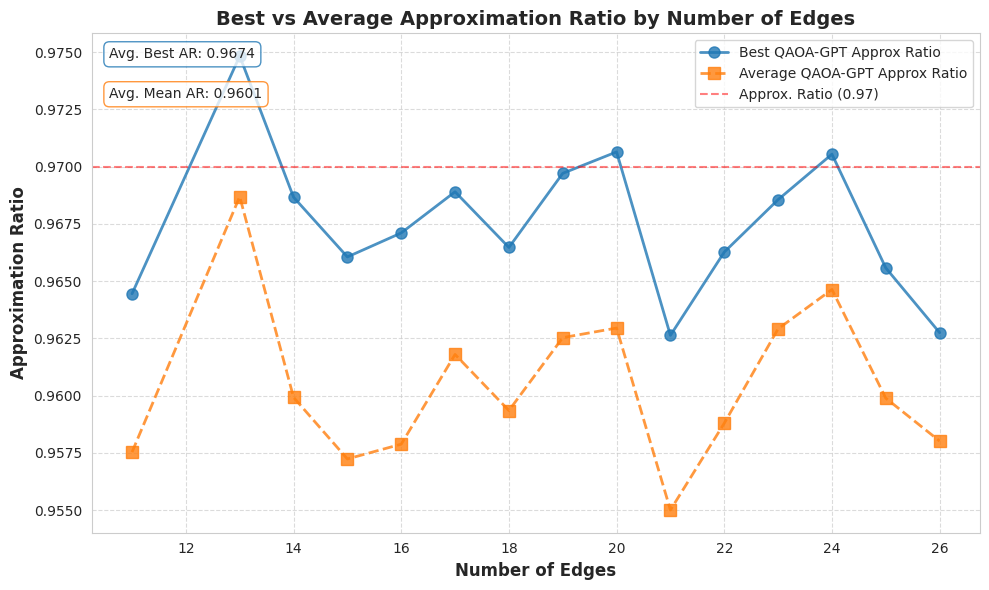

Average QAOA-GPT best approximation ratio: 0.9674
Average QAOA-GPT mean approximation ratio: 0.9601
Difference between best and avg AR: 0.0073


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Group by n_edges and calculate mean for both metrics
grouped_best = filtered_df[['n_edges', 'best_adapt_gpt_ar']].groupby('n_edges').mean().reset_index()
grouped_avg = filtered_df[['n_edges', 'avg_adapt_gpt_ar']].groupby('n_edges').mean().reset_index()

# Create the plot with two lines
plt.plot(
    grouped_best['n_edges'], 
    grouped_best['best_adapt_gpt_ar'], 
    'o-',
    color='#1f77b4',
    linewidth=2,
    markersize=8,
    alpha=0.8,
    label='Best QAOA-GPT Approx Ratio'
)

plt.plot(
    grouped_avg['n_edges'], 
    grouped_avg['avg_adapt_gpt_ar'], 
    's--',
    color='#ff7f0e',
    linewidth=2,
    markersize=8,
    alpha=0.8,
    label='Average QAOA-GPT Approx Ratio'
)

# Enhance the plot appearance
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Number of Edges', fontsize=12, fontweight='bold')
plt.ylabel('Approximation Ratio', fontsize=12, fontweight='bold')
plt.title('Best vs Average Approximation Ratio by Number of Edges', fontsize=14, fontweight='bold')

# Add a horizontal line at y=0.97 (near-optimal approximation)
plt.axhline(y=0.97, color='red', linestyle='--', alpha=0.5, label='Approx. Ratio (0.97)')

# Show the overall averages
best_avg = filtered_df['best_adapt_gpt_ar'].mean()
avg_avg = filtered_df['avg_adapt_gpt_ar'].mean()

# Add text boxes for the averages
plt.text(
    0.02, 0.95, f'Avg. Best AR: {best_avg:.4f}',
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round,pad=0.4", facecolor='white', edgecolor='#1f77b4', alpha=0.8)
)

plt.text(
    0.02, 0.87, f'Avg. Mean AR: {avg_avg:.4f}',
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round,pad=0.4", facecolor='white', edgecolor='#ff7f0e', alpha=0.8)
)

# Add legend and adjust layout
plt.legend()
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Average QAOA-GPT best approximation ratio: {best_avg:.4f}")
print(f"Average QAOA-GPT mean approximation ratio: {avg_avg:.4f}")
print(f"Difference between best and avg AR: {(best_avg - avg_avg):.4f}")

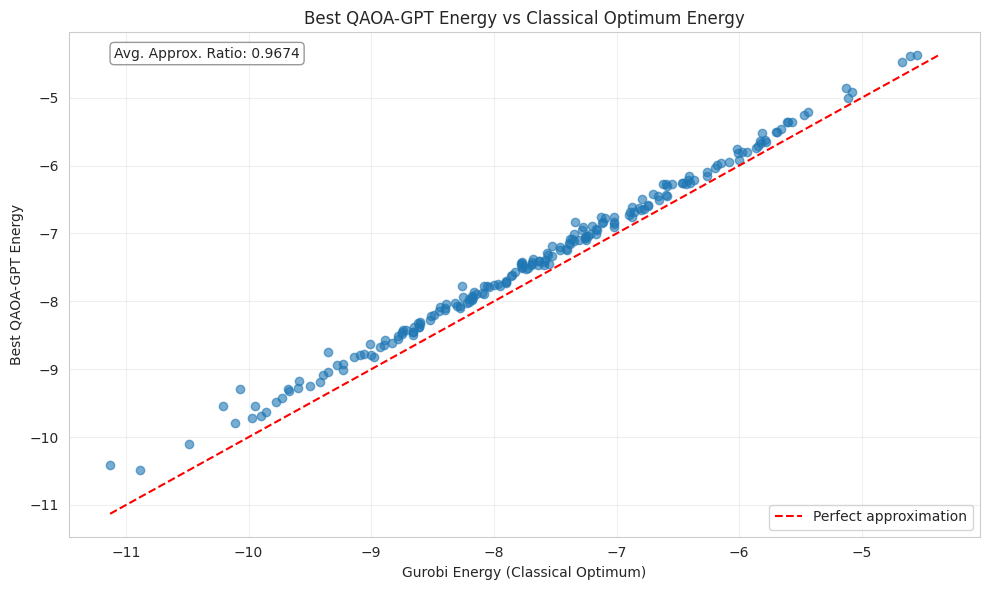

Average approximation ratio: 0.9674
Min approximation ratio: 0.9231
Max approximation ratio: 0.9864


In [16]:
import matplotlib.pyplot as plt

# Create a new column with the best energy from each row's adapt_gpt_energies
filtered_df['best_adapt_gpt_energy'] = filtered_df.apply(
    lambda x: x['adapt_gpt_energies'] if isinstance(x['adapt_gpt_energies'], (int, float))
    else min(x['adapt_gpt_energies']),
    axis=1
)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['energy_gurobi'], filtered_df['best_adapt_gpt_energy'], alpha=0.6)

# Add a diagonal line representing y=x (perfect approximation)
max_val = max(filtered_df['energy_gurobi'].max(), filtered_df['best_adapt_gpt_energy'].max())
min_val = min(filtered_df['energy_gurobi'].min(), filtered_df['best_adapt_gpt_energy'].min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect approximation')

# Add labels and title
plt.xlabel('Gurobi Energy (Classical Optimum)')
plt.ylabel('Best QAOA-GPT Energy')
plt.title('Best QAOA-GPT Energy vs Classical Optimum Energy')
plt.grid(True, alpha=0.3)
plt.legend()

# Add a text box with the average approximation ratio
avg_ratio = filtered_df['best_adapt_gpt_ar'].mean()
plt.annotate(f'Avg. Approx. Ratio: {avg_ratio:.4f}', 
             xy=(0.05, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Average approximation ratio: {avg_ratio:.4f}")
print(f"Min approximation ratio: {filtered_df['best_adapt_gpt_ar'].min():.4f}")
print(f"Max approximation ratio: {filtered_df['best_adapt_gpt_ar'].max():.4f}")

Average number of new_layer occurrences per circuit: 7.62


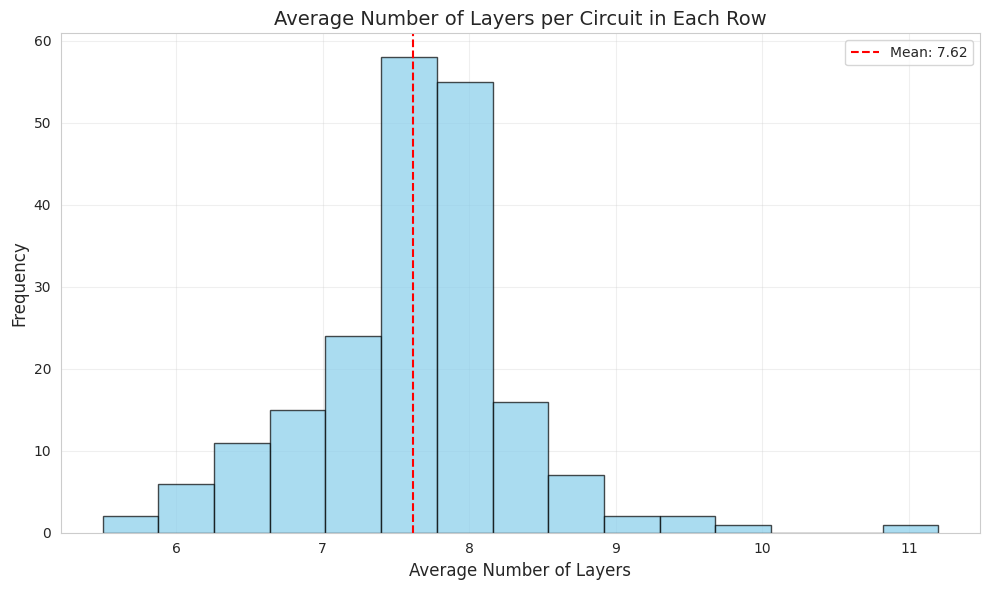

In [17]:
# Calculate average number of layers per circuit for each row
filtered_df['avg_layers_per_circuit'] = filtered_df['q_circuits'].apply(
    lambda x: np.mean([str(circuit).count('new_layer_p') for circuit in x]) if isinstance(x, list)
    else str(x).count('new_layer_p')
)

# Calculate the overall average (mean of means)
mean_of_means = filtered_df['avg_layers_per_circuit'].mean()
print(f"Average number of new_layer occurrences per circuit: {mean_of_means:.2f}")

# Visualize the distribution of average layers per row

plt.figure(figsize=(10, 6))
plt.hist(filtered_df['avg_layers_per_circuit'], bins=15, alpha=0.7, 
         color='skyblue', edgecolor='black')
plt.axvline(mean_of_means, color='red', linestyle='--', 
            label=f'Mean: {mean_of_means:.2f}')
plt.title('Average Number of Layers per Circuit in Each Row', fontsize=14)
plt.xlabel('Average Number of Layers', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()